In [28]:
import pandas as pd
import pandas_profiling
from pandas.api.types import CategoricalDtype
from matplotlib import pyplot as plt
from scipy import stats

In [29]:
pip list --format=freeze > requirements-1-ja-data-wrangling.ipynb.txt

Note: you may need to restart the kernel to use updated packages.


Load the 2 data files and see what is there.  Using the [Cookiecutter data science structure](https://drivendata.github.io/cookiecutter-data-science/) as a guide for the project structure.

In [30]:
df = pd.read_csv('../data/raw/diabetic_data.csv')
print(df.head())
print(df.shape)

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

encounter_id seems redundant with the dataframe index if it is unique.  Using the encounter_id as the index will make it easier to tie the dataframe back to the source and/or .csv file.

In [31]:
print(df['encounter_id'].isna().sum(), 'missing values')
print(df['encounter_id'].duplicated().sum(), 'duplicates')

working_df = df.set_index('encounter_id')

0 missing values
0 duplicates


patient_nbr seems like another target for this treatment.

In [32]:
print(df['patient_nbr'].isna().sum(), 'missing values')
duplicates = df['patient_nbr'].duplicated(keep=False).sum()
print(round(duplicates / df.shape[0] * 100), '% patient_nbr involved as duplicate')

0 missing values
46 % patient_nbr involved as duplicate


46% of the dataset having a patient_nbr that is duplicated means that the feature is not redundant to the index.  It should be possible to use patient number to check the readmitted feature.  Any patient with a readmission should appear in the dataset at least twice.  Any patient without a readmission should only appear once.

In [33]:
print(df['readmitted'].isna().sum())
print(df['readmitted'].value_counts())

# one end of a readmit chain will have a no value in this column.
# filtering on == no would pull those in as well, so i need to 
# filter on the inverse of the readmitted != no.

readmit = set(df[(df['readmitted'] != 'NO')]['patient_nbr'])
single = set(df.drop_duplicates(subset='patient_nbr', keep=False)['patient_nbr'])
print(len(readmit & single), 'patient_nbrs only appear once and have a postive readmitted value')
print(len(single - readmit), 'patient_nbrs only appear once and have a negative readmitted value')

0
NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64
12044 patient_nbrs only appear once and have a postive readmitted value
42701 patient_nbrs only appear once and have a negative readmitted value


This was an interesting diversion, but this could be that for the singles with a readmission, the rest of the readmission chain happened outside of the date range included in the dataset.  It could also be that the rest of the chain happened in a facility or with a provider that isn't represented in the set.  According to the [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3996476/#) the dataset was collected for, the readmitted feature indicates whether or not that row's encounter resulted in a readmission.  As the target is predicting readmission, having the first in the chain is valuable, even if the second is not available.  No treatment is needed here.

Moving on to checking for missing values and general looks at the distribution in the remaining features

In [34]:
profile = df.profile_report(samples=None, 
                            correlations=None, 
                            duplicates=None, 
                            interactions=None)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/59 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

1. the top 2 values for race represent 94% of the dataset.  the remaining 6% can be combined into "other".
2. 3 observations have missing gender values.  these can be removed.
3. age is binned into ordinal categories and could benefit from being handled with ordinality in mind.
4. Weight is very often missing, represented with only a "?" and will be removed.
5. the top admission types of 4, 7 and 8 have low representation and should be combined into "other" a value of 5 or 6 is "not available" and will also fall into the "other" category.
6. discharge disposition would benefit from the same treatment, holding 1, 3 and 6 out, combining all others.  
7. again for admission source, holding 1 and 7 out.
8. payer_code is missing for 40% of observations.  any kind of imputation would be contrived enough to skew the results, so it will be removed.
9. the same for medical specialty, but missing for 49% of all observations.
10. diag_1, diag_2 and diag_3 have high cardinality and this will need to be reduced.  the original study grouped these according to ICD groupings and this will be handled in pre-processing.
11. examide, citoglipton, troglitazone and acetohexamide have constant or very nearly constant values and will be removed.
12. there are several other single medications that have very skewed distributions, but it may be possible to combine these into medication categories during pre-processing, so they will be left in place for this pass.
13. all of the compound medications except glyburide-metformin will be removed for the same constant or nearly constant problem.

In [35]:
# 4, 8, 9, 11, 13
to_drop = ['weight',
           'payer_code',
           'medical_specialty',
           'examide',
           'citoglipton',
           'troglitazone',
           'acetohexamide',
           'glipizide-metformin',
           'glimepiride-pioglitazone', 
           'metformin-rosiglitazone',
           'metformin-pioglitazone',
          ]

working_df.drop(columns=to_drop, inplace=True)
working_df.columns

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [36]:
# 1

to_replace = ['?',
              'Hispanic',
              'Asian'
             ]

working_df['race'].replace(to_replace=to_replace, value='Other', inplace=True)
working_df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Other               6457
Name: race, dtype: int64

In [37]:
working_df.dtypes

patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone        

In [38]:
#2
to_delete = working_df[~(working_df['gender'].isin(['Female','Male']))].index
working_df.drop(to_delete, inplace=True)
working_df['gender'].value_counts()

Female    54708
Male      47055
Name: gender, dtype: int64

In [39]:
#3
working_df['age'] = working_df['age'].astype(CategoricalDtype(ordered=True))

In [40]:
#5, 6, 7

to_categorical = ['admission_type_id',
                  'discharge_disposition_id',
                  'admission_source_id'
                 ]

for col in to_categorical:
    working_df[col] = working_df[col].astype('category')
    
def negReplace (col, to_keep, val):
    all_vals = set(col)
    to_replace = all_vals - to_keep
    return col.replace(to_replace=to_replace, value=val)
    
to_keep = set([1, 2, 3])
working_df['admission_type_id'] = negReplace(working_df['admission_type_id'], to_keep, 'Other')

to_keep = set([1, 3, 6])
working_df['discharge_disposition_id'] = negReplace(working_df['discharge_disposition_id'], to_keep, 'Other')

to_keep = set([1, 7])
working_df['admission_source_id'] = negReplace(working_df['admission_source_id'], to_keep, 'Other')

to_replace = {1: 'emergency', 
              2: 'urgent',
              3: 'elective',     
             }
working_df['admission_type_id'] = working_df['admission_type_id'].replace(to_replace)


to_replace = {1: 'home', 
              3: 'snf',
              6: 'home health',     
             }
working_df['discharge_disposition_id'] = working_df['discharge_disposition_id'].replace(to_replace)

to_replace = {1: 'physicial referral', 
              7: 'emergency room',
             }
working_df['admission_source_id'] = working_df['admission_source_id'].replace(to_replace)


Check the profile again.

In [41]:
profile = working_df.profile_report(samples=None, 
                                    correlations=None, 
                                    duplicates=None, 
                                    interactions=None)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Time for outliers in the remaining numeric features.  This is important as they will have a large impact on any scaling and any model weights.  From the profile, each of these variables has a relatively 

In [42]:
numerics = working_df[['time_in_hospital',
            'num_lab_procedures',
            'num_procedures',
            'num_medications',
            'number_outpatient',
            'number_emergency',
            'number_inpatient',
            'number_diagnoses']]

profile = numerics.profile_report(samples=None, 
                                  correlations=None, 
                                  duplicates=None, 
                                  interactions=None)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In looking at the distributions of the the numeric features, time_in_hospital looks like a log normal distribution and has no exceptional values.  num_procedures also has no extreme values.  num_medications has a long-ish tail and should be examined closer.

count    101763.000000
mean         16.021835
std           8.127589
min           1.000000
25%          10.000000
50%          15.000000
75%          20.000000
max          81.000000
Name: num_medications, dtype: float64
90%tile 26.0
99%tile 43.0


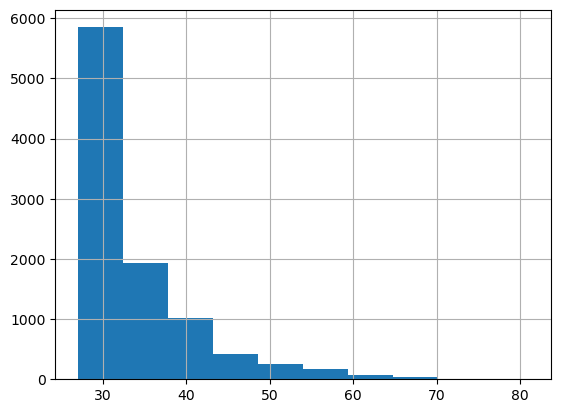

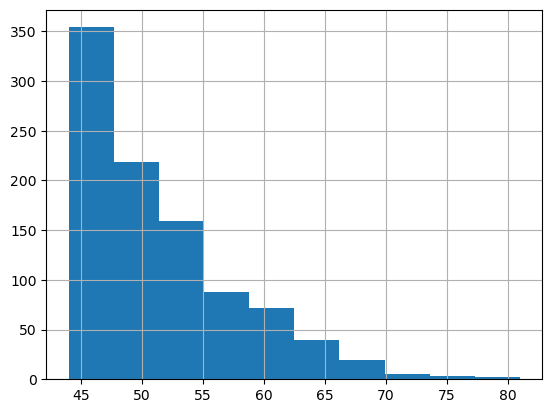

1

In [43]:
def lookAtRightTail (col):
    print(col.describe())
    print('90%tile', col.quantile(.9))
    print('99%tile', col.quantile(.99))
    col[col > col.quantile(.9)].hist()
    plt.show()
    col[col > col.quantile(.99)].hist()
    plt.show()
    return 1

lookAtRightTail(numerics['num_medications'])

The distribution of num_medications tapers off at a uniform rate and although the right tail is exaggerated, it looks like the values are all valid and there are no outliers.  This feature may benefit from a log transformation during preprocessing.  Next is num_lab_procedures.

count    101763.000000
mean         43.095909
std          19.674220
min           1.000000
25%          31.000000
50%          44.000000
75%          57.000000
max         132.000000
Name: num_lab_procedures, dtype: float64
90%tile 67.0
99%tile 85.0


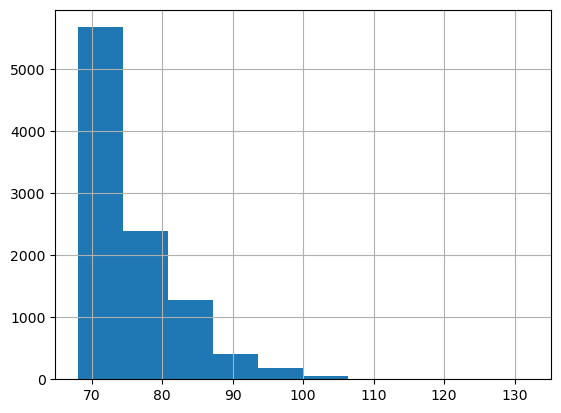

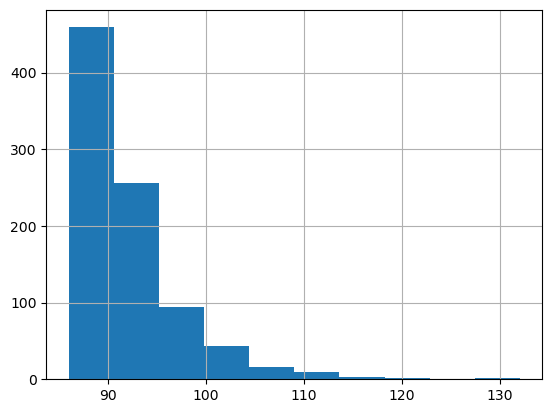

1

In [44]:
lookAtRightTail(numerics['num_lab_procedures'])

It does look like the tail after 120 are outliers.  There are 4 observations that fit this criteria, but nothing else about these records looks unusual.  For now, they will be considered candidates for removal.  number_outpatient is next.

In [45]:
print(numerics[numerics['num_lab_procedures'] > 120])

outliers = list(numerics[numerics['num_lab_procedures'] > 120].index)

              time_in_hospital  num_lab_procedures  num_procedures  \
encounter_id                                                         
52701030                    13                 129               5   
238167534                    8                 132               3   
274455804                   12                 121               6   
309003956                    9                 126               0   

              num_medications  number_outpatient  number_emergency  \
encounter_id                                                         
52701030                   45                  1                 1   
238167534                  24                  0                 1   
274455804                  32                  0                 0   
309003956                  23                  6                 1   

              number_inpatient  number_diagnoses  
encounter_id                                      
52701030                     1                 8  
23816

count    101763.000000
mean          0.369368
std           1.267282
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          42.000000
Name: number_outpatient, dtype: float64
90%tile 1.0
99%tile 5.0


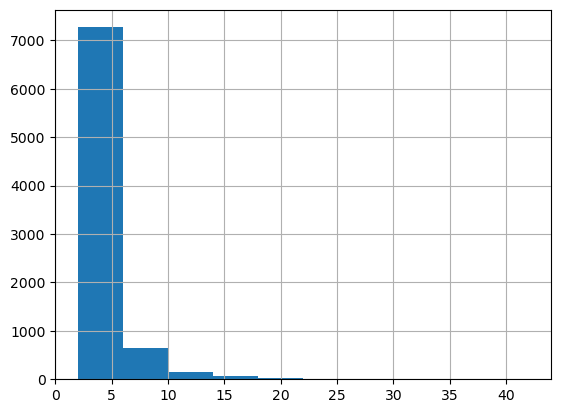

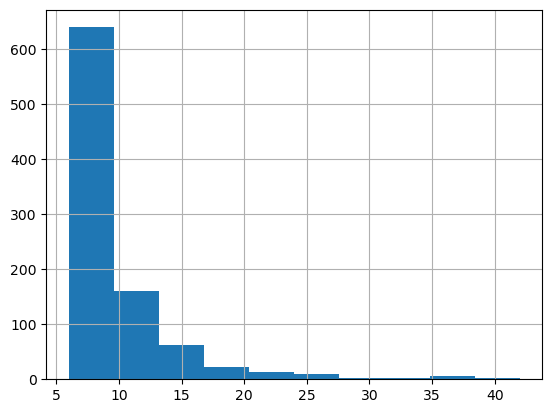

12


In [46]:
lookAtRightTail(numerics['number_outpatient'])
print(numerics[numerics['number_outpatient'] > 30].shape[0])

30 looks like the flat point in this curve with 12 observations falling above that range.  These will be appended to the outliers list.  number_emergency is next.

In [47]:
outliers += list(numerics[numerics['number_outpatient'] > 30].index)

count    101763.000000
mean          0.197842
std           0.930485
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          76.000000
Name: number_emergency, dtype: float64
90%tile 1.0
99%tile 3.0


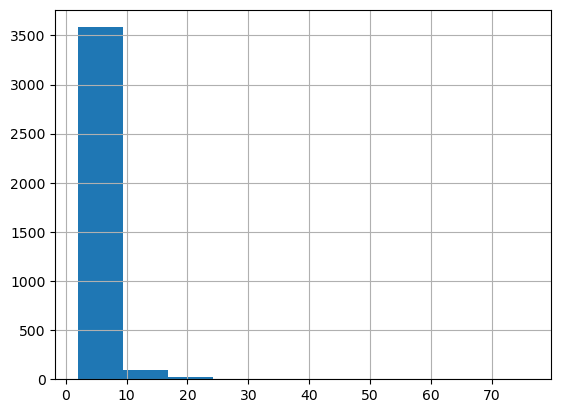

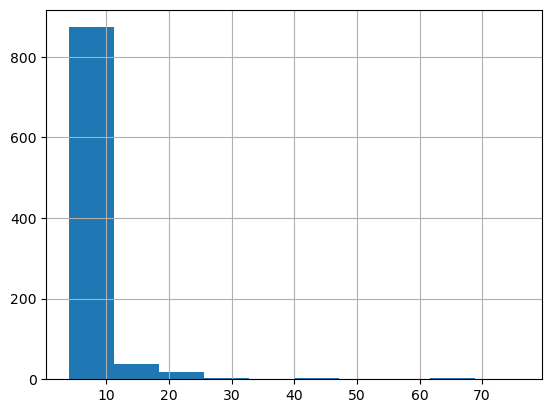

20


In [48]:
lookAtRightTail(numerics['number_emergency'])
print(numerics[numerics['number_emergency'] > 20].shape[0])

20 looks like the flat point in this curve with 20 observations falling above that range.  These will be appended to the outliers list.  number_inpatient is next.

In [49]:
outliers += list(numerics[numerics['number_emergency'] > 20].index)

count    101763.000000
mean          0.635585
std           1.262877
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          21.000000
Name: number_inpatient, dtype: float64
90%tile 2.0
99%tile 6.0


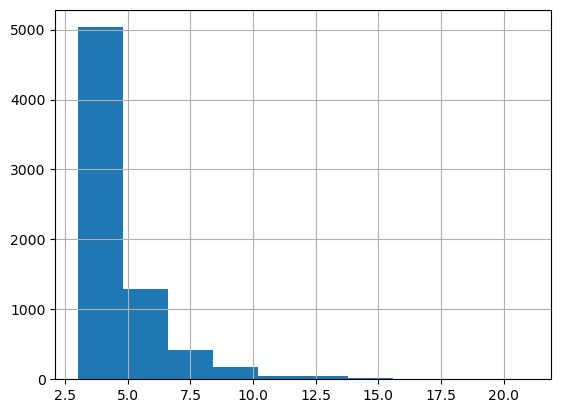

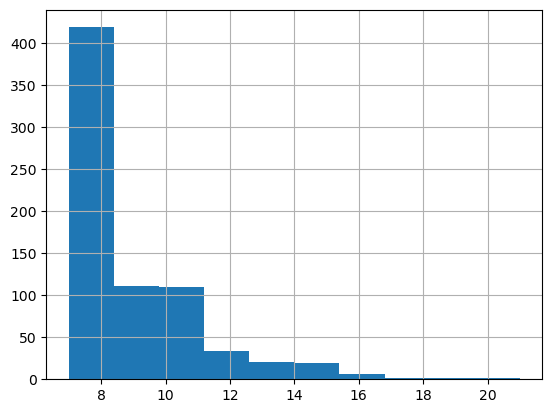

1

In [50]:
lookAtRightTail(numerics['number_inpatient'])

This curve seems to fall off naturally.  number_diagnoses last.

count    101763.000000
mean          7.422649
std           1.933578
min           1.000000
25%           6.000000
50%           8.000000
75%           9.000000
max          16.000000
Name: number_diagnoses, dtype: float64
90%tile 9.0
99%tile 9.0


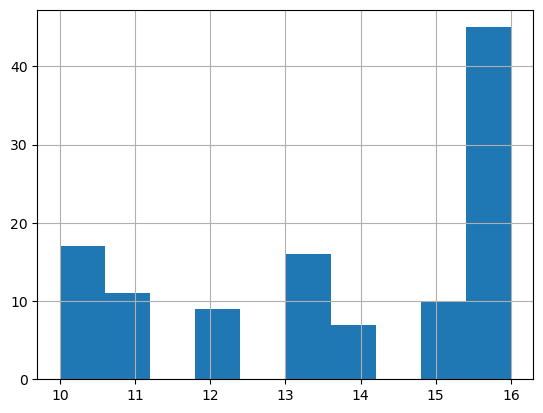

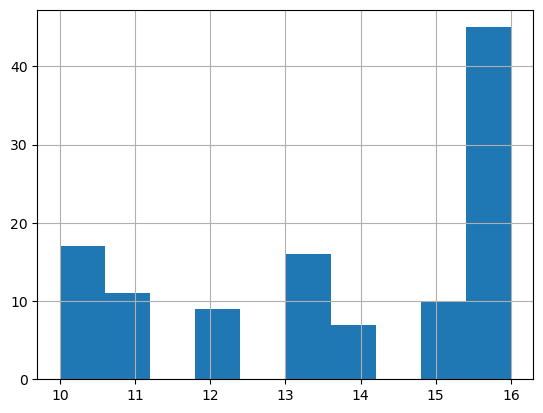

1

In [51]:
lookAtRightTail(numerics['number_diagnoses'])

This does look a bit unnatural, but not like outliers.  It could be that 16 was the maximum number of entries that could be added in the source system.  This may skew results, but is unavoidable and will have to be included in the report.  

In [52]:
print(len(set(outliers)), 'outliers')
print('representing', round(len(set(outliers)) / len(working_df) * 100, 2), '% of oberservations')

36 outliers
representing 0.04 % of oberservations


With so few outliers, these can be removed from the data with no undue effect on analysis.

In [53]:
working_df.drop(outliers, inplace=True)

Drop the cleaned data into a csv for the next step in processing.

In [54]:
working_df.to_csv('../data/interim/notebook1_output.csv')